+----+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|  id|              id_job|feature_type_1_stand_0|feature_type_1_stand_1|feature_type_1_stand_2|feature_type_1_stand_3|feature_type_1_stand_4|feature_type_1_stand_5|feature_type_1_stand_6|feature_type_1_stand_7|feature_type_1_stand_8|feature_type_1_stand_9|
+----+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|1000|-6241722208723555...|             1.8741186|             1.6593567|             0.8987507|             1.1503949|             1.0942012|            0.68286616|            0.90509206|             1.2402405|             1.

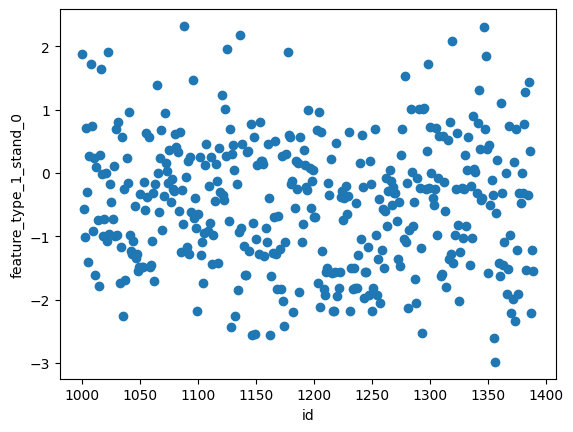

In [13]:
from os import getcwd
from pyspark.sql import SparkSession
from pyspark.sql.functions import stddev, mean, col, udf, lit
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt
import pandas

spark = SparkSession.builder.appName("jooble-test").getOrCreate()

# Define function to compute Z-score
def z_score(x, mean, stddev): 
    return (x - mean) / stddev

# Convert function which compute Z-score into UDF
z_score_udf = udf(z_score, FloatType())

def transform_data(input_test_path, input_train_path, output_path, prefix="feature_type_1"):
    """
    Transform data in CSV format by computing the Z-score for each value in selected columns.
    
    Parameters:
        input_test_path (str): Path to the input test CSV file.
        input_train_path (str): Path to the input CSV file with training data.
        output_path (str): Path to the output CSV file.
        prefix (str): Column header's prefix (pattern) which is about to transform
    """
    # Load *.csv
    train_df = spark.read.csv(input_train_path, header=True, inferSchema=True)
    test_df = spark.read.csv(input_test_path, header=True, inferSchema=True)

    # Enumerate column headers which starts with `feature_type_1`
    feature_cols = [ header for header in test_df.columns if header.startswith(prefix) ]

    # Iterate over feature_type_1_{i} columns and perform z-standardization for each value in a feature column
    for feature_col in feature_cols:
        mean_val = lit(train_df.select(mean(feature_col)).collect()[0][0])
        stddev_val = lit(train_df.select(stddev(feature_col)).collect()[0][0])

        new_column_name = "{}_stand{}".format(prefix, feature_col.removeprefix(prefix))

        test_df = test_df.withColumn(feature_col, z_score_udf(col(feature_col), mean_val, stddev_val))\
                         .withColumnRenamed(feature_col, new_column_name)

    # Write transformed data to output CSV file with pandas to avoid fragmentation
    test_df.toPandas().to_csv(output_path)

    return test_df


def Plot_dataframe(dataframe, y_col: str, x_col: str, title: str = ""):
    pandas_df = dataframe.select(col(y_col), col(x_col)).toPandas()

    # Build the scatter plot
    plt.scatter(pandas_df[y_col], pandas_df[x_col])
    plt.xlabel(y_col)
    plt.ylabel(x_col)
    plt.title(title)
    return plt


if __name__ == "__main__":
    WorkDir = getcwd()
    train_data_path = f"../data/input/train.csv"
    test_data_path = f"../data/input/test.csv"
    output_data_path = f"../data/output/test_transformed.csv"
    
    transformed = transform_data(test_data_path, train_data_path, output_data_path, prefix="feature_type_1")
    transformed.show()

    plot = Plot_dataframe(transformed, y_col = "id", x_col = "feature_type_1_stand_0")
    plot.show()

    spark.stop()
